In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

sns.color_palette("viridis", as_cmap=True)

# Load the preprocessed dataset
train_features = pd.read_csv('train_features.csv')
# print(train_features.head(10))


# Create product type mapping
product_type_map = {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}
train_features['product_name'] = train_features['product_type'].map(product_type_map)
print(train_features.head(10))

   county  is_business  product_type   target  is_consumption  \
0       0            0             1    0.713               0   
1       0            0             1   96.590               1   
2       0            0             2    0.000               0   
3       0            0             2   17.314               1   
4       0            0             3    2.904               0   
5       0            0             3  656.859               1   
6       0            1             0    0.000               0   
7       0            1             0   59.000               1   
8       0            1             1    0.000               0   
9       0            1             1  501.760               1   

              datetime  data_block_id  row_id  prediction_unit_id        date  \
0  2021-09-01 00:00:00              0       0                   0  2021-09-01   
1  2021-09-01 00:00:00              0       1                   0  2021-09-01   
2  2021-09-01 00:00:00              0    

In [18]:
# Convert datetime strings to datetime objects if needed
if isinstance(train_features['datetime'][0], str):
    train_features['datetime'] = pd.to_datetime(train_features['datetime'])

# Define separate dataframes for consumption and production
consumption = train_features[train_features['is_consumption'] == True].copy()
production = train_features[train_features['is_consumption'] == False].copy()

# Rename target columns for clarity
consumption = consumption.rename(columns={'target': 'consumption'})
production = production.rename(columns={'target': 'production'})

# Extract key identifiers for matching consumption and production
key_columns = ['county', 'is_business', 'product_type', 'datetime', 'month', 'week', 'date', 'hour', 
               'data_block_id', 'prediction_unit_id', 'euros_per_mwh_electricity']

# Merge consumption and production data
merged_data = pd.merge(
    consumption[key_columns + ['consumption']],
    production[key_columns + ['production']],
    on=key_columns,
    how='outer'
)

# Fill NaN values with 0 (in case there's only consumption or only production for some entries)
merged_data['consumption_kWh'] = merged_data['consumption'].fillna(0)
merged_data['production_kWh'] = merged_data['production'].fillna(0)

# Calculate imbalance (positive means excess consumption, negative means excess production)
merged_data['imbalance_MWh'] = (merged_data['consumption'] - merged_data['production']) / 1000
print(merged_data.head(10)[['product_type', 'consumption', 'production', 'imbalance_MWh']])
merged_data['abs_imbalance_MWh'] = abs(merged_data['imbalance_MWh'])

   product_type  consumption  production  imbalance_MWh
0             1       96.590       0.713       0.095877
1             1       77.691       1.132       0.076559
2             1       91.594       0.490       0.091104
3             1       87.955       0.496       0.087459
4             1       88.184       0.149       0.088035
5             1       89.781       0.298       0.089483
6             1       96.481       1.271       0.095210
7             1       94.592      22.122       0.072470
8             1       77.308      64.257       0.013051
9             1       54.211     170.312      -0.116101


In [19]:
# Add product names
merged_data['product_name'] = merged_data['product_type'].map(product_type_map)

# Calculate financial impact of imbalance
merged_data['imbalance_cost'] = merged_data['imbalance_MWh'] * merged_data['euros_per_mwh_electricity']

# Filter rows where euros_per_mwh_electricity is not NaN
filtered_data = merged_data[merged_data['euros_per_mwh_electricity'].notna()]
# Print the filtered rows
print(filtered_data.head(10)[['product_type', 'consumption', 'production', 'imbalance_MWh', 'euros_per_mwh_electricity', 'imbalance_cost']])


    product_type  consumption  production  imbalance_MWh  \
24             1      109.366       1.687       0.107679   
25             1       97.033       1.785       0.095248   
26             1      104.854       1.199       0.103655   
27             1      103.433       0.826       0.102607   
28             1      105.858       0.897       0.104961   
29             1      105.432       0.681       0.104751   
30             1      111.971       1.545       0.110426   
31             1       94.903      22.755       0.072148   
32             1       73.104      82.675      -0.009571   
33             1       43.940     212.584      -0.168644   

    euros_per_mwh_electricity  imbalance_cost  
24                      92.51        9.961384  
25                      88.90        8.467547  
26                      87.35        9.054264  
27                      86.88        8.914496  
28                      88.43        9.281701  
29                      93.58        9.802599  
30 

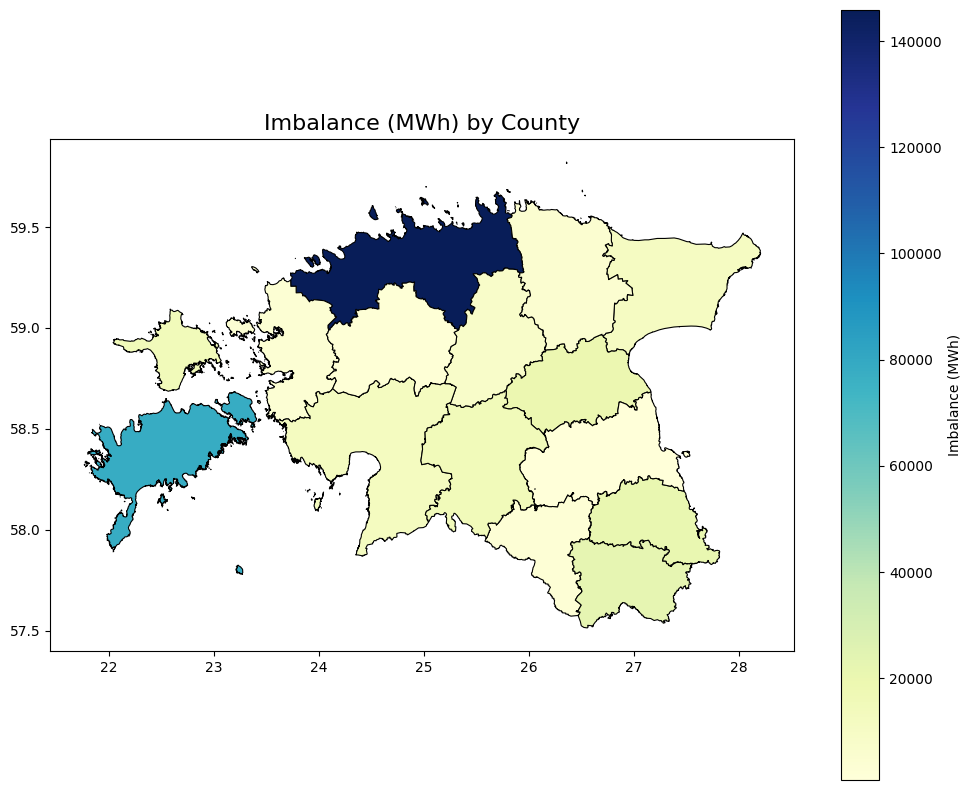

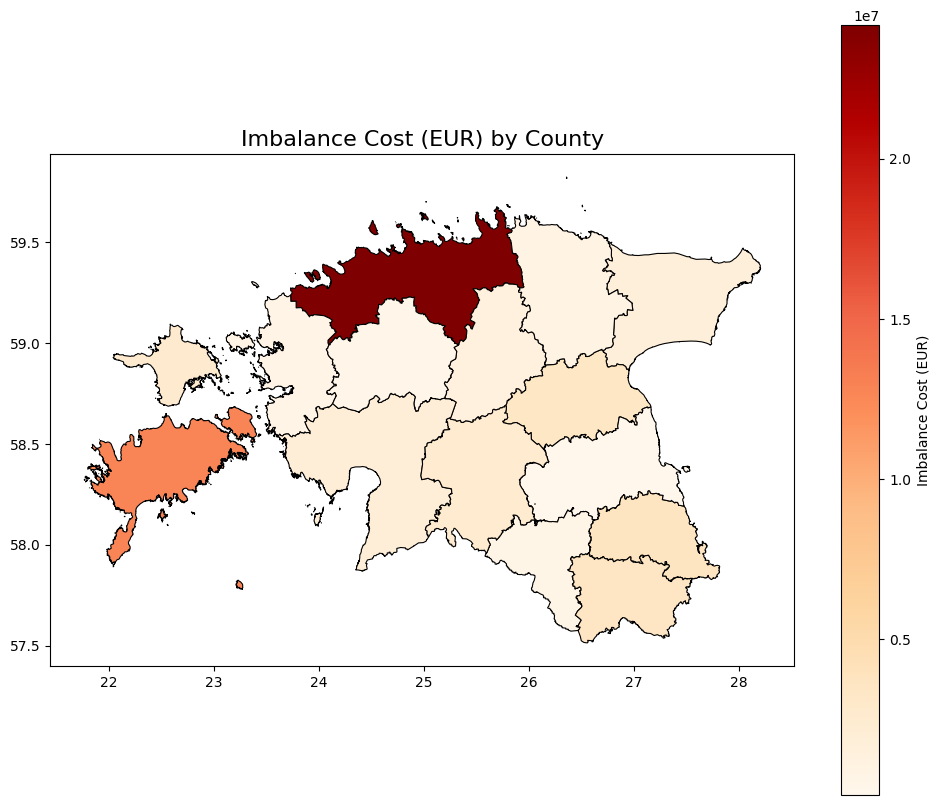

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Mapping county ID to names
county_map = {
    0: "harju",
    1: "tartu",
    2: "ida-viru",
    3: "pärnu",
    4: "viljandi",
    5: "võru",
    6: "rapla",
    7: "jõgeva",
    8: "valga",
    9: "lääne",
    10: "hiiu",
    11: "saare",
    12: "järva",
    13: "lääne-viru",
    14: "põlva"
}

# Map county IDs to names in the data
merged_data["county_name"] = merged_data["county"].map(county_map)
merged_data["county_name"] = merged_data["county_name"].astype(str).str.lower().str.strip()

# Load Estonia counties GeoJSON file
estonia_gdf = gpd.read_file("estonia_counties.json")

# Fix mismatched names between GeoJSON and data
geo_name_fix = {
    "Harjumaa": "harju",
    "Tartumaa": "tartu",
    "Ida-Virumaa": "ida-viru",
    "Pärnumaa": "pärnu",
    "Viljandimaa": "viljandi",
    "Võrumaa": "võru",
    "Raplamaa": "rapla",
    "Jõgevamaa": "jõgeva",
    "Valgamaa": "valga",
    "Läänemaa": "lääne",
    "Hiiumaa": "hiiu",
    "Saaremaa": "saare",
    "Järvamaa": "järva",
    "Põlvamaa": "põlva",
    "Lääne-Virumaa": "lääne-viru"
}

estonia_gdf["county_name"] = estonia_gdf["NAME_1"].replace(geo_name_fix).str.lower().str.strip()

# Aggregate imbalance metrics by county
region_summary = merged_data.groupby("county_name").agg({
    "imbalance_MWh": "sum",
    "imbalance_cost": "sum"
}).reset_index()

# Merge GeoDataFrame with imbalance data
choropleth_df = estonia_gdf.merge(region_summary, on="county_name", how="left")

# Plot imbalance_MWh
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
choropleth_df.plot(
    column="imbalance_MWh",
    cmap="YlGnBu",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Imbalance (MWh)"},
    ax=ax
)
ax.set_title("Imbalance (MWh) by County", fontsize=16)
plt.show()

# Plot imbalance_cost
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
choropleth_df.plot(
    column="imbalance_cost",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Imbalance Cost (EUR)"},
    ax=ax
)
ax.set_title("Imbalance Cost (EUR) by County", fontsize=16)
plt.show()

In [4]:


# Calculate daily volatility metrics by contract type
daily_volatility = merged_data.groupby(['date', 'product_name']).agg({
    'imbalance': ['mean', 'std', 'min', 'max'],
    'abs_imbalance': 'mean',
    'euros_per_mwh_electricity': 'mean'
}).reset_index()

# Flatten multi-level column names
daily_volatility.columns = ['_'.join(col).strip('_') for col in daily_volatility.columns.values]

# Calculate coefficient of variation (relative volatility)
daily_volatility['imbalance_cv'] = np.abs(daily_volatility['imbalance_std'] / daily_volatility['imbalance_mean'])
daily_volatility['imbalance_range'] = daily_volatility['imbalance_max'] - daily_volatility['imbalance_min']

# Analyze hourly patterns
hourly_patterns = merged_data.groupby(['product_name', 'hour']).agg({
    'imbalance': 'mean',
    'abs_imbalance': 'mean',
    'euros_per_mwh_electricity': 'mean'
}).reset_index()

# Let's visualize the results

# # 1. Average imbalance by contract type
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='product_name', y='imbalance', data=merged_data)
# plt.title('Distribution of Imbalance by Contract Type')
# plt.xlabel('Contract Type')
# plt.ylabel('Imbalance (Consumption - Production)')
# plt.tight_layout()
# plt.savefig('imbalance_by_contract.png')
# plt.close()

# 2. Imbalance volatility by contract type
plt.figure(figsize=(12, 6))
sns.boxplot(x='product_name', y='imbalance_std', data=daily_volatility)
plt.title('Daily Imbalance Volatility by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Standard Deviation of Imbalance')
plt.tight_layout()
plt.savefig('imbalance_volatility_by_contract.png')
plt.close()

# 3. Hourly imbalance patterns by contract type
plt.figure(figsize=(14, 8))
for product in product_type_map.values():
    product_data = hourly_patterns[hourly_patterns['product_name'] == product]
    plt.plot(product_data['hour'], product_data['imbalance'], label=product)
plt.title('Average Hourly Imbalance by Contract Type')
plt.xlabel('Hour of Day')
plt.ylabel('Average Imbalance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('hourly_imbalance_by_contract.png')
plt.close()

# 4. Hourly imbalance vs. electricity prices
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot average electricity price by hour
hour_prices = merged_data.groupby('hour')['euros_per_mwh_electricity'].mean()
ax1.plot(hour_prices.index, hour_prices.values, 'r-', label='Avg Electricity Price')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Electricity Price (EUR/MWh)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for imbalance
ax2 = ax1.twinx()
for product in product_type_map.values():
    product_data = hourly_patterns[hourly_patterns['product_name'] == product]
    ax2.plot(product_data['hour'], product_data['imbalance'], label=product)
ax2.set_ylabel('Average Imbalance', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Add legend for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Hourly Electricity Prices vs. Contract Type Imbalances')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('price_vs_imbalance_hourly.png')
plt.close()

# 5. Calculate price disadvantage metrics
# Create time periods for analysis (peak vs. off-peak)
merged_data['time_period'] = 'off-peak'
merged_data.loc[(merged_data['hour'] >= 8) & (merged_data['hour'] <= 20), 'time_period'] = 'peak'

# Calculate price disadvantage by contract type and time period
price_disadvantage = merged_data.groupby(['product_name', 'time_period']).agg({
    'imbalance': 'mean',
    'imbalance_cost': 'mean',
    'euros_per_mwh_electricity': 'mean'
}).reset_index()

# Calculate normalized disadvantage (cost per unit of imbalance)
price_disadvantage['normalized_cost'] = price_disadvantage['imbalance_cost'] / price_disadvantage['imbalance'].apply(lambda x: x if abs(x) > 0.01 else 0.01)

# Plot price disadvantage by contract type and time period
plt.figure(figsize=(14, 7))
sns.barplot(x='product_name', y='imbalance_cost', hue='time_period', data=price_disadvantage)
plt.title('Average Imbalance Cost by Contract Type and Time Period')
plt.xlabel('Contract Type')
plt.ylabel('Average Imbalance Cost (EUR)')
plt.tight_layout()
plt.savefig('imbalance_cost_by_contract.png')
plt.close()

# 6. Analyze relationship between solar radiation and imbalance
# Add solar radiation info back to merged data
solar_columns = ['direct_solar_radiation_h_mean', 'shortwave_radiation_h_mean', 'diffuse_radiation_h_mean']

# Create lookup dataframe for solar radiation
solar_lookup = train_features[['datetime', 'county', 'is_business', 'product_type'] + solar_columns].drop_duplicates()

# Merge solar data with our analysis dataframe
merged_data = pd.merge(
    merged_data,
    solar_lookup,
    on=['datetime', 'county', 'is_business', 'product_type'],
    how='left'
)

# Create solar utilization metrics
merged_data['production_per_radiation'] = np.where(
    merged_data['direct_solar_radiation_h_mean'] > 0,
    merged_data['production'] / merged_data['direct_solar_radiation_h_mean'],
    0
)

# Group by contract type and analyze solar utilization
solar_utilization = merged_data.groupby('product_name').agg({
    'production_per_radiation': ['mean', 'std'],
    'direct_solar_radiation_h_mean': 'mean',
    'production': 'mean'
}).reset_index()

# Flatten column names
solar_utilization.columns = ['_'.join(col).strip('_') for col in solar_utilization.columns.values]

# 7. Plot solar utilization by contract type
plt.figure(figsize=(12, 6))
sns.barplot(x='product_name', y='production_per_radiation_mean', data=solar_utilization)
plt.title('Solar Utilization by Contract Type (Production per Unit of Solar Radiation)')
plt.xlabel('Contract Type')
plt.ylabel('Production / Solar Radiation')
plt.tight_layout()
plt.savefig('solar_utilization_by_contract.png')
plt.close()

# 8. Analyze price correlation with imbalance volatility by contract type and season
# Add seasonal information
merged_data['season'] = 'winter'
merged_data.loc[merged_data['month'].isin([3, 4, 5]), 'season'] = 'spring'
merged_data.loc[merged_data['month'].isin([6, 7, 8]), 'season'] = 'summer'
merged_data.loc[merged_data['month'].isin([9, 10, 11]), 'season'] = 'fall'

# Calculate weekly metrics by contract type and season
weekly_metrics = merged_data.groupby(['week', 'product_name', 'season']).agg({
    'imbalance': ['std', 'mean'],
    'abs_imbalance': 'mean',
    'euros_per_mwh_electricity': ['mean', 'std'],
    'direct_solar_radiation_h_mean': 'mean'
}).reset_index()

# Flatten column names
weekly_metrics.columns = ['_'.join(col).strip('_') for col in weekly_metrics.columns.values]

# Plot correlation between price and imbalance volatility with seasonal comparison
plt.figure(figsize=(16, 10))
seasons = weekly_metrics['season'].unique()
products = weekly_metrics['product_name'].unique()

for i, season in enumerate(seasons):
    plt.subplot(2, 2, i+1)
    for product in products:
        product_data = weekly_metrics[(weekly_metrics['product_name'] == product) & 
                                      (weekly_metrics['season'] == season)]
        plt.scatter(product_data['euros_per_mwh_electricity_mean'], 
                   product_data['imbalance_std'], 
                   label=product, alpha=0.7, s=50)
    
    plt.title(f'Price vs. Imbalance Volatility - {season.capitalize()}')
    plt.xlabel('Average Weekly Electricity Price (EUR/MWh)')
    plt.ylabel('Weekly Imbalance Volatility (Std Dev)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('seasonal_price_vs_volatility.png')
plt.close()

# 9. Business vs Non-business comparison by contract type
# Add business dimension to our analysis
business_comparison = merged_data.groupby(['product_name', 'is_business']).agg({
    'imbalance': ['mean', 'std'],
    'imbalance_cost': 'mean',
    'production_per_radiation': 'mean',
    'direct_solar_radiation_h_mean': 'mean',
    'euros_per_mwh_electricity': 'mean'
}).reset_index()

# Flatten column names
business_comparison.columns = ['_'.join(col).strip('_') for col in business_comparison.columns.values]

# # Plot business vs non-business imbalance by contract type
# plt.figure(figsize=(14, 7))
# business_comparison['is_business_label'] = business_comparison['is_business'].map({True: 'Business', False: 'Non-Business'})
# sns.barplot(x='product_name', y='imbalance_mean', hue='is_business_label', data=business_comparison)
# plt.title('Average Imbalance by Contract Type and Business Status')
# plt.xlabel('Contract Type')
# plt.ylabel('Average Imbalance')
# plt.tight_layout()
# plt.savefig('business_vs_nonbusiness_imbalance.png')
# plt.close()

# # 10. Price impact by business status and contract type
# plt.figure(figsize=(14, 7))
# sns.barplot(x='product_name', y='imbalance_cost_mean', hue='is_business_label', data=business_comparison)
# plt.title('Average Imbalance Cost by Contract Type and Business Status')
# plt.xlabel('Contract Type')
# plt.ylabel('Average Imbalance Cost (EUR)')
# plt.tight_layout()
# plt.savefig('business_vs_nonbusiness_cost.png')
# plt.close()

# Print summary statistics
print("Summary of Imbalance by Contract Type:")
print(merged_data.groupby('product_name').agg({
    'imbalance': ['mean', 'std', 'min', 'max'],
    'abs_imbalance': 'mean',
    'imbalance_cost': 'mean'
}))

print("\nPrice Disadvantage Analysis:")
print(price_disadvantage)

print("\nSolar Utilization by Contract Type:")
print(solar_utilization)

print("\nBusiness vs Non-Business Comparison:")
print(business_comparison)

# Create a comprehensive summary dataframe with key findings
summary = pd.DataFrame({
    'product_name': list(product_type_map.values()),
    'avg_imbalance': [merged_data[merged_data['product_name'] == p]['imbalance'].mean() for p in product_type_map.values()],
    'imbalance_volatility': [merged_data[merged_data['product_name'] == p]['imbalance'].std() for p in product_type_map.values()],
    'peak_price_impact': [price_disadvantage[(price_disadvantage['product_name'] == p) & 
                                           (price_disadvantage['time_period'] == 'peak')]['imbalance_cost'].values[0] 
                         if not price_disadvantage[(price_disadvantage['product_name'] == p) & 
                                                (price_disadvantage['time_period'] == 'peak')].empty else np.nan 
                         for p in product_type_map.values()],
    'off_peak_price_impact': [price_disadvantage[(price_disadvantage['product_name'] == p) & 
                                               (price_disadvantage['time_period'] == 'off-peak')]['imbalance_cost'].values[0]
                             if not price_disadvantage[(price_disadvantage['product_name'] == p) & 
                                                    (price_disadvantage['time_period'] == 'off-peak')].empty else np.nan
                             for p in product_type_map.values()],
    'solar_utilization': [solar_utilization[solar_utilization['product_name'] == p]['production_per_radiation_mean'].values[0]
                         if not solar_utilization[solar_utilization['product_name'] == p].empty else np.nan
                         for p in product_type_map.values()]
})

print("\nComprehensive Summary by Contract Type:")
print(summary)

# 11. County-level analysis to look at geographical inequalities
county_analysis = merged_data.groupby(['county', 'product_name']).agg({
    'imbalance': ['mean', 'std'],
    'production_per_radiation': 'mean',
    'imbalance_cost': 'mean'
}).reset_index()

# Flatten column names
county_analysis.columns = ['_'.join(col).strip('_') for col in county_analysis.columns.values]

# Find the counties with the worst solar utilization (lowest production per radiation)
worst_solar_counties = county_analysis.sort_values('production_per_radiation_mean').groupby('product_name').head(3)
print("\nCounties with Poorest Solar Utilization by Contract Type:")
print(worst_solar_counties[['county', 'product_name', 'production_per_radiation_mean', 'imbalance_cost_mean']])

# Find counties with highest financial disadvantage
worst_financial_counties = county_analysis.sort_values('imbalance_cost_mean', ascending=False).groupby('product_name').head(3)
print("\nCounties with Highest Financial Disadvantage by Contract Type:")
print(worst_financial_counties[['county', 'product_name', 'imbalance_cost_mean', 'imbalance_mean']])

Summary of Imbalance by Contract Type:
                  imbalance                                    abs_imbalance  \
                       mean          std        min        max          mean   
product_name                                                                   
Combined         401.362440   394.736998  -3938.318   2651.774    434.811559   
Fixed             95.211462   282.703196  -3382.640   2318.222    153.364591   
General service   28.134372    57.310405   -231.748    698.319     35.593452   
Spot             656.365894  1731.996465 -11150.198  15474.057    835.376143   

                imbalance_cost  
                          mean  
product_name                    
Combined          66071.781969  
Fixed             16254.992302  
General service    4356.733331  
Spot             109314.887562  

Price Disadvantage Analysis:
      product_name time_period   imbalance  imbalance_cost  \
0         Combined    off-peak  415.595955    55186.998374   
1         Combi

<Figure size 1400x600 with 0 Axes>

/var/folders/kf/pwqzhqdn00n58n744fr8c_500000gn/T/ipykernel_49265/2406029341.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_data['utilization'] = solar_data['target'] / solar_data['installed_capacity_client']


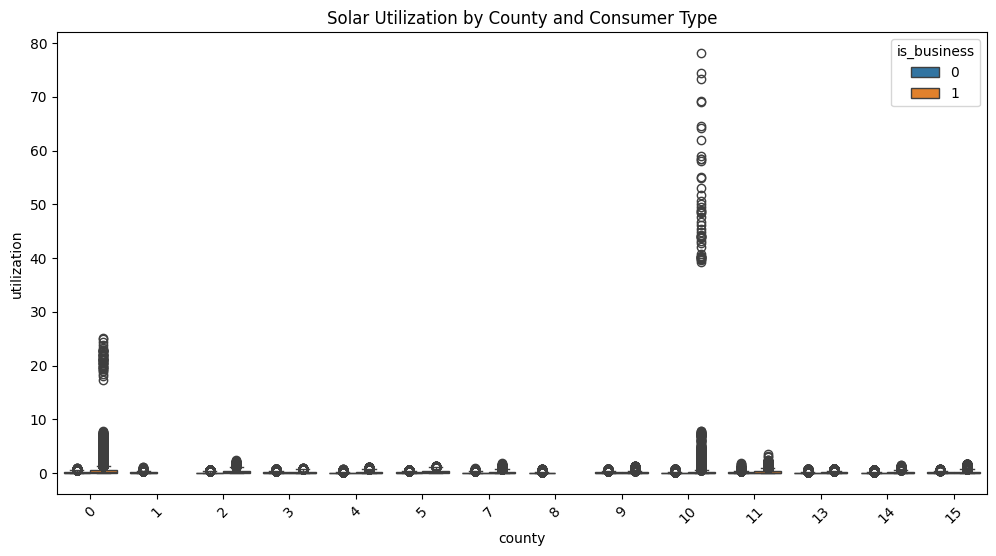

/var/folders/kf/pwqzhqdn00n58n744fr8c_500000gn/T/ipykernel_49265/2406029341.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  price_analysis = solar_data.groupby(['county', 'is_business']).apply(


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv('train_features.csv')

# Focus on solar production (adjust based on your product_type values)
solar_data = train[train['product_type'].isin([0,1,2])]  # Example - verify actual values

# Calculate utilization
solar_data['utilization'] = solar_data['target'] / solar_data['installed_capacity_client']

# Analyze by county and consumer type
utilization_summary = solar_data.groupby(['county', 'is_business', 'product_type'])['utilization'].agg(['mean', 'std', 'count'])

# Plot utilization disparities
plt.figure(figsize=(12,6))
sns.boxplot(x='county', y='utilization', hue='is_business', data=solar_data)
plt.title('Solar Utilization by County and Consumer Type')
plt.xticks(rotation=45)
plt.show()

# Analyze price disadvantages
price_analysis = solar_data.groupby(['county', 'is_business']).apply(
    lambda x: pd.Series({
        'avg_price': x['euros_per_mwh_electricity'].mean(),
        'price_variability': x['euros_per_mwh_electricity'].std(),
        'corr_utilization_price': x['utilization'].corr(x['euros_per_mwh_electricity'])
    })
).reset_index()